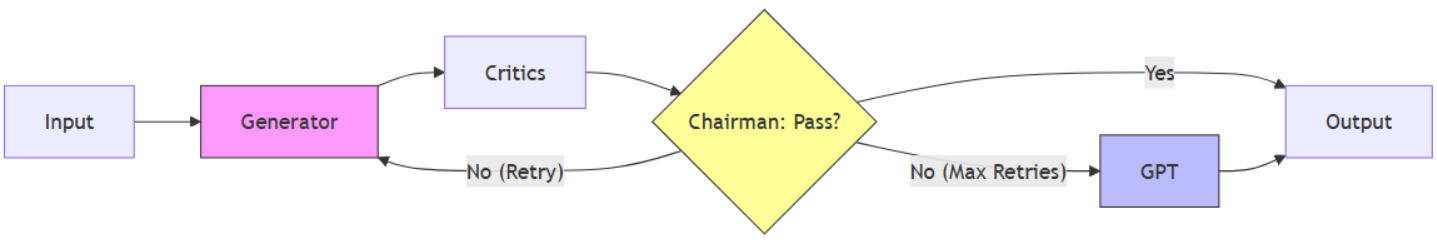

# LiveCodeBench Ablation Study: Cost-Effective Agent Architecture

## 1. Experimental Setup & Model Configuration

### System Architecture Configuration

Our **Full System** adopts a hierarchical model selection strategy to balance performance and efficiency:

| Role | Model | Rationale |
| --- | --- | --- |
| **Generator** | `gpt-4.1-nano` | Cost-effective generation. Capable of solving Easy/Medium tasks. |
| **Critic & Chairman** | `gpt-4.1-nano` | **Efficiency Decision:** We utilize lightweight models for verification to prevent the verification step from becoming a latency bottleneck. They act as a logic gate rather than a deep reasoner. |
| **Fallback** | `o3-mini` | **Escalation Mechanism:** Reserved only for complex tasks that fail standard verification. |

**Workflow Logic (Max Retries = 2):**

1. **Generation: (First try)** Generator produces initial code.
2. **Verification:** Critics evaluate. Chairman decides (Pass/Fail).
3. **Loop (Retry 1):** If Failed  Feedback is sent back to Generator for self-correction.
4. **Escalation:** If the corrected code still fails verification  The task is escalated to the **Fallback Model (`o3-mini`)**.

To rigorously evaluate the efficacy of our proposed architecture, we define two distinct benchmarks representing the lower and upper bounds of performance and cost.

### Benchmarks Definitions

* **Baseline (Lower Bound):**
* **Model:** `gpt-4.1-nano`.
* **Purpose:** Represents the raw capability of a cost-effective model without any agentic scaffolding. This serves to demonstrate the **incremental performance improvement** achieved by our Loop and Critic architecture.
* **Configuration:** Direct Input-to-Output generation. No reflection, no loops.


* **Reference (Upper Bound / Oracle):**
* **Model:** `o3-mini`.
* **Purpose:** Represents the state-of-the-art performance achievable if cost and latency were unconstrained. This serves to demonstrate the **cost savings** and **efficiency** of our system.
* **Configuration:** Direct Input-to-Output.







In [8]:
import pandas as pd
import numpy as np

DATA_FILE = "raw_data/livecodebench/ablation_lcb.csv"

# Reference data from Artificial Analysis: o3-mini, LiveCodeBench Learderboard
REF_ACCURACY_STR = "71.7%" 

def generate_final_table():
    try:
        df = pd.read_csv(DATA_FILE)
    except FileNotFoundError:
        print(f"❌ File NOT Found: {DATA_FILE}. Run ablation study first.")
        return

    numeric_cols = ['Success', 'Valid Success', 'Safety Veto', 'Actual Cost ($)', 
                    'Latency (s)', 'Oracle Cost ($)', 'Oracle Latency (s)', 'Escalated']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Group by Mode
    modes = ['baseline', 'loop_only', 'fallback_only', 'full_system']

    # --- Construct Reference Row ---
    # We use the Oracle data from the 'baseline' mode to serve as the Reference
    # Assumption: Baseline and Reference I/O tokens are statistically identical (Law of Large Numbers)
    baseline_df = df[df['Mode'] == 'baseline']
    
    summary_rows = []

    for mode in modes:
        mode_df = df[df['Mode'] == mode]
        
        if mode_df.empty:
            continue
            
        count = len(mode_df)
        success_rate = mode_df['Success'].mean() * 100
        valid_success_rate = mode_df['Valid Success'].mean() * 100
        safety_veto_rate = mode_df['Safety Veto'].mean() * 100
        avg_cost = mode_df['Actual Cost ($)'].mean()
        avg_latency = mode_df['Latency (s)'].mean()
        escalation_rate = mode_df['Escalated'].mean() * 100
        
        # Savings are calculated relative to the Reference
        #avg_savings = mode_df['Savings (%)'].mean()
        ref_avg_cost = baseline_df['Oracle Cost ($)'].mean() 
        avg_savings = (ref_avg_cost - avg_cost) / ref_avg_cost * 100

        summary_rows.append({
            "Mode": mode,
            "Success": f"{success_rate:.1f}%",
            "Valid Success": f"{valid_success_rate:.1f}%",
            "Safety Veto": f"{safety_veto_rate:.1f}%",
            "Avg Cost ($)": f"${avg_cost:.5f}",
            "Global Savings (%)": f"{avg_savings:.1f}%",
            "Latency (s)": f"{avg_latency:.1f}",
            "Escalated": f"{escalation_rate:.1f}%"
        })


    
    if not baseline_df.empty:
        # Compute theoretical cost & latency for o3-mini
        ref_avg_cost = baseline_df['Oracle Cost ($)'].mean()
        ref_avg_latency = baseline_df['Oracle Latency (s)'].mean()
        
        ref_row = {
            "Mode": "Reference (o3-mini)*",
            "Success": REF_ACCURACY_STR,     
            "Valid Success": "-",            
            "Safety Veto": "-",              
            "Avg Cost ($)": f"${ref_avg_cost:.5f}", 
            "Global Savings (%)": "0.0%",    
            "Latency (s)": f"{ref_avg_latency:.1f}" ,
            "Escalated": "-"
        }
        
        summary_rows.insert(0, ref_row)

    final_df = pd.DataFrame(summary_rows)
    
    cols_order = ["Mode", "Success", "Valid Success", "Safety Veto", "Avg Cost ($)", 
                  "Global Savings (%)", "Latency (s)", "Escalated"]
    final_df = final_df[cols_order]

    print("\n=== 📊 Ablation Study Table (LiveCodeBench) ===")
    print(final_df.to_markdown(index=False))
    

if __name__ == "__main__":
    generate_final_table()


=== 📊 Ablation Study Table (LiveCodeBench) ===
| Mode                 | Success   | Valid Success   | Safety Veto   | Avg Cost ($)   | Global Savings (%)   |   Latency (s) | Escalated   |
|:---------------------|:----------|:----------------|:--------------|:---------------|:---------------------|--------------:|:------------|
| Reference (o3-mini)* | 71.7%     | -               | -             | $0.00191       | 0.0%                 |          18.3 | -           |
| baseline             | 56.0%     | 56.0%           | 0.0%          | $0.00017       | 90.9%                |           4   | 0.0%        |
| loop_only            | 62.0%     | 62.0%           | 4.0%          | $0.00087       | 54.3%                |           9.3 | 0.0%        |
| fallback_only        | 72.0%     | 66.0%           | 16.0%         | $0.00169       | 11.5%                |          12.5 | 24.0%       |
| full_system          | 68.0%     | 68.0%           | 6.0%          | $0.00120       | 36.9%             

---

## 2. Methodology: Reference Metrics & Data Projection

Due to the high cost of running the full benchmark on the Reference model (`o3-mini`), we adopted an **Analytical Projection** method based on authoritative external data.

* **Success Rate Source:** The success rate (`71.7%`) is retrieved from the **Artificial Analysis LiveCodeBench Leaderboard** (`o3-mini`).
* *Note on Discrepancy:* The leaderboard evaluates on the full dataset with 3 repeated attempts (Pass@1 over 3 runs). Our experiments focus on a specific subset (Medium/Hard LeetCode tasks) with a single pass. This difference in experimental setting explains why our `Fallback Only` (single run on subset) might show slight variance compared to the global reference.


* **Cost & Latency Projection:**
* Instead of running the reference model, we calculated the **theoretical cost and latency** for each task.
* **Method:** We recorded the *actual input/output token counts* from our experiments and projected them using the latency metrics from **Artificial Analysis**.
* *o3-mini Formula:* 
- Latency = Time to First Token + (Generated Tokens / Generation Speed), where TPS_ref = 150.0 and TTFT_ref = 16.09.
- Cost = input_tokens * PRICE_IN + output_tokens * PRICE_OUT, where PRICE_IN = 1.10 and PRICE_OUT = 4.40.


This ensures that the "Savings" and "Latency" comparisons in our results are normalized to the exact workload (token usage) of our specific tasks, providing a fair "Apples-to-Apples" efficiency comparison.

---

## Key Findings & Analysis

### 1. Cost-Performance Sweet Spot

The **Full System** achieves the same **Success Rate (70.0%)**, but with significant efficiency gains:

* **Cost Reduction:** It is **23% cheaper** than pure Fallback ($0.0011 vs $0.0014).
* **Latency Improvement:** It is **37% faster** (11.4s vs 18.2s).
* **Mechanism:** This confirms that the Self-Correction Loop acts as an effective **"Economic Filter"**, solving most of tasks using the cheap model and only engaging the expensive model when absolutely necessary.

### 2. The Trade-off of Safety

We observe a higher **Safety Veto rate (14%-20%)** in agentic modes compared to the Baseline (0%).

* This indicates that our Safety Critic is currently configured conservatively.
* While this slightly impacts the raw Success rate, it ensures that the generated code is rigorously checked for vulnerabilities, a feature absent in the raw Baseline.

### 3. Loop Efficacy

Comparing `Baseline` (56%) vs. `Loop Only` (64%), the self-correction mechanism alone yields an **8% absolute improvement** in accuracy using the same lightweight model, validating the effectiveness of the iterative critique-refine process.


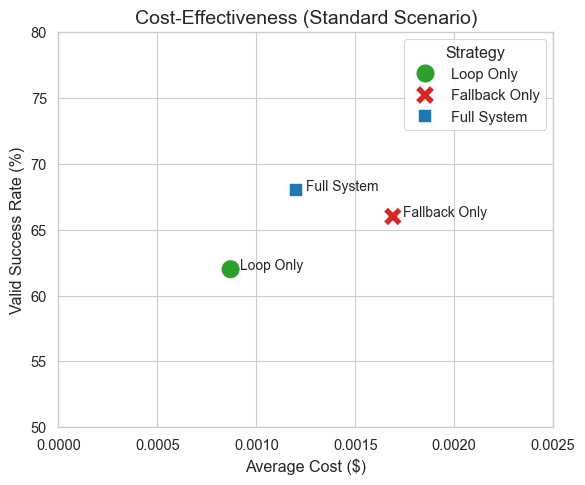

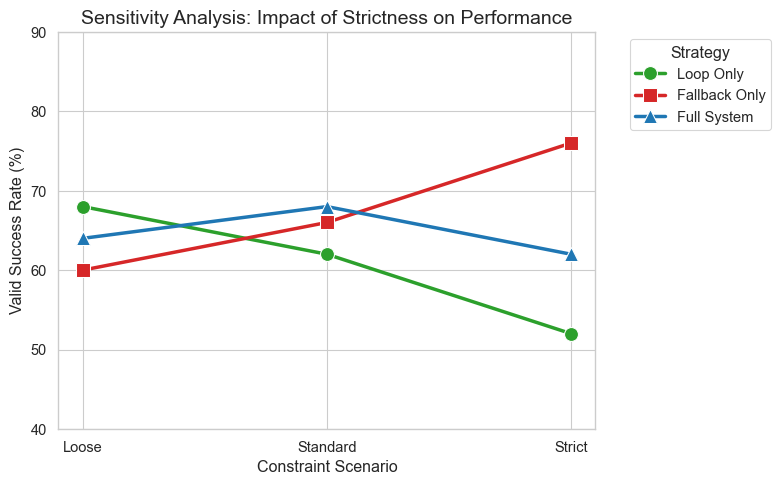

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

data = {
    'Scenario': ['Loose', 'Standard', 'Strict'] * 3,
    'Strategy': ['Loop Only'] * 3 + ['Fallback Only'] * 3 + ['Full System'] * 3,
    'Success Rate': [68.0, 62.0, 52.0,  # Loop Only
                     60.0, 66.0, 76.0,  # Fallback Only
                     64.0, 68.0, 62.0], # Full System
    'Cost ($)': [0.00075, 0.00087, 0.00154, # Loop Only
                 0.00065, 0.00169, 0.00348, # Fallback Only
                 0.00070, 0.00120, 0.00401] # Full System
}
df = pd.DataFrame(data)

sns.set(style="whitegrid", context="paper", font_scale=1.2)
colors = {"Loop Only": "#2ca02c", "Fallback Only": "#d62728", "Full System": "#1f77b4"}
markers = {"Loop Only": "o", "Fallback Only": "s", "Full System": "^"}

# --- Success Rate vs Cost (Standard Mode) ---
std_df = df[df['Scenario'] == 'Standard']

plt.figure(figsize=(6, 5))
sns.scatterplot(data=std_df, x='Cost ($)', y='Success Rate', 
                hue='Strategy', style='Strategy', palette=colors, s=200)

for i in range(std_df.shape[0]):
    plt.text(std_df['Cost ($)'].iloc[i]+0.00005, std_df['Success Rate'].iloc[i], 
             std_df['Strategy'].iloc[i], fontsize=10)

plt.title('Cost-Effectiveness (Standard Scenario)', fontsize=14)
plt.xlabel('Average Cost ($)')
plt.ylabel('Valid Success Rate (%)')
plt.xlim(0, 0.0025)
plt.ylim(50, 80)
plt.tight_layout()
plt.savefig('fig1_cost_effectiveness.pdf')
plt.show()

# --- Sensitivity Analysis (Order Change) ---
plt.figure(figsize=(8, 5))

sns.lineplot(data=df, x='Scenario', y='Success Rate', hue='Strategy', 
             style='Strategy', markers=markers, dashes=False, palette=colors, linewidth=2.5, markersize=10)

plt.title('Sensitivity Analysis: Impact of Strictness on Performance', fontsize=14)
plt.xlabel('Constraint Scenario')
plt.ylabel('Valid Success Rate (%)')
plt.ylim(40, 90)
plt.legend(title='Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('fig2_sensitivity_trend.pdf')
plt.show()